# Simulated Examples

This notebook demonstrates both the BART_SURVIVAL package `simulation` and `suv_bart` modules.

The `simulation` module will be used to generate simulated Survival type datasets and `surv_bart` will be used to complete the Survival analyses. 

The `scikit-survival` package will be used to addionally for comparison and to complete some additional metric evaluations.

The raw `.ipynb` file can be found in the `examples` directory in the github repository.

In [2]:
import numpy as np
import sksurv as sks
from bart_survival import surv_bart as sb 
from bart_survival import simulation as sm
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Simulation Matrix 

A covariate matrix is generated below. A few key parameters include:
- `N` = number of observations
- `x_vars` = number of covariates
- `VAR_CLASS` = list containing the upper range of the covariate values.
    - Each covariate is drawn from a uniform distribution with the lower bound == 0 and upper bound == VAR_CLASS[i].
    - VAR_CLASS == 2 is a reserved for generating a binary variable [values == 0,1]. The distribution of the binary variables is set by VAR_PROB.
- `VAR_PROB` = None for all VAR_CLASS != 2 and a probability value for VAR_CLASS == 2.
- `rng` = numpy random number generator. 
    - If not set rng will reset with each call to get_x_matrix.

If `len(VAR_CLASS)` is less than `x_vars` the covariate matrix will be filled with uniform(0,1) covariates up to size of `x_vars`

In [331]:
rng = np.random.default_rng(1)

# create the covariate matrix
# - 100 obs, 5 vars, [binary, binary, 0-5, 0-1, 0-1]
x_mat = sm.get_x_matrix(
    N=1000,
    x_vars=5,
    VAR_CLASS=[2,2,1],
    VAR_PROB=[.5, .7, None],
    rng = rng
)

x_mat[0:10,:]

array([[1.        , 1.        , 0.284     , 0.11526701, 0.68893629],
       [1.        , 0.        , 0.01      , 0.87859741, 0.53159136],
       [0.        , 0.        , 0.11      , 0.29933889, 0.74260155],
       [1.        , 1.        , 0.131     , 0.74592912, 0.89760035],
       [0.        , 1.        , 0.432     , 0.93736634, 0.45782069],
       [0.        , 1.        , 0.776     , 0.35489974, 0.03277996],
       [1.        , 1.        , 0.404     , 0.93135644, 0.76689895],
       [0.        , 1.        , 0.146     , 0.88222506, 0.45901483],
       [1.        , 0.        , 0.168     , 0.12161778, 0.7825713 ],
       [0.        , 1.        , 0.953     , 0.12783193, 0.85355997]])

Returned is a 2d ndarray. 

If a more complex covariate matrix is needed, it can be constructed outside of this function and passed to the simulation step.

## Generate Survival Simulation

Using the covariate matrix `x_mat`, simulated survival data can be generated using `simulate_survival()`

`simulate_survival` uses a 2-parameter weibull distribution to generate both:
- simulated event times
- true Survival probabilities and hazard rates

The two parameters required are a the `scale_f` and `shape_f`. Both are formatted as `str` type equation that is evaluated to produce the simulation and true survival components.

By using both scale and shape, a variety of Survival settings can be simulated including proportional hazards and non-proportional hazards (when `shape_f` incorporates the covariate matrix).

- `scale_f` 
  
  In form "np.exp($B_0$ + $B_1$ * x_mat[:,0] + ... + $B_N$ * x_mat[:,N])"
    
    The linear equation must be contained in an $exp()$, which is necessary for the parameterization of the Weibull distribution.

    When resolved, a larger scale value will result in a shrunk SV curve and a smaler scale value will result in a stretched SV curve.

- `shape_f`
  
  In form "A"; where A is any real number. 

  Or form "A + $A_N$ * x_mat[:,N] + ..." 

  When shape_f > 1 the Hazard rate will increase.
  When shape_f < 1 the Hazaard rate will decrease.
  When shape_f == 1 then the Hazard rate is constant and the Weibull distribution resolves to an Exponential function.

  When shape_f includes "x_mat", then the resulting SV curves will not follow the assumption of proportional hazards.

- `eos`  

  Allows the simulated SV times and true SV curves to be truncated at the EOS time point.

- `cens_scale`

  Allows incorporation of censoring at random.

- `time_scale`

  Allows reduction of time series by a factor of the provided value. 

  So time series [1,2,3,4,5,6,8,9,10] w/ `time_scale=2` will resolve to [2,4,6,8,10]. 

  This becomes relevant when completing the Survival analyses. The algorithm evaluates all time points in the series up to the event time, which can be computationaly heavy. Reducing the time series by a scaling factor reduces this burden. The surv_bart module has additional functionality for scaling the time-series.

Covariates not included in the `scale_f` equation will have no impact on the outcome
    



In [332]:
event_dict, sv_true, sv_scale_true = sm.simulate_survival(
    x_mat = x_mat,
    scale_f = "np.exp(4 + .4*x_mat[:,0] + .1*x_mat[:,1] + .01*x_mat[:,2])", # note that x_mat[:,3] and x_mat[:,4] are not included
    shape_f = "1", # hazard is constant
    eos = 180,
    cens_scale=None,
    time_scale=60,
    true_only=False,
    rng = rng
)

mean shape 1.0
mean scale 73.33053395906819
mean time draws 70.07190944565642


In [333]:
np.exp(.4)
np.exp(.2)
np.exp(.1)
# np.log(1.5)

1.1051709180756477

The simulated SV data can be accessed by `event_dict`

In [334]:
print("Time of event")
print(event_dict["t_event"][0:5])
print("Status at event time")
print(event_dict["status"][0:5])

print("Scaled event times")
print(event_dict["t_event_scale"][0:5])

Time of event
[[180.]
 [ 26.]
 [132.]
 [180.]
 [ 28.]]
Status at event time
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]]
Scaled event times
[[3.]
 [1.]
 [3.]
 [3.]
 [1.]]


The actual SV data can be accessed through `sv_true` and `sv_true_scale`.

A plot of the actual survival curves is shown below. 
These curves are what will be predicted by the survival analyses

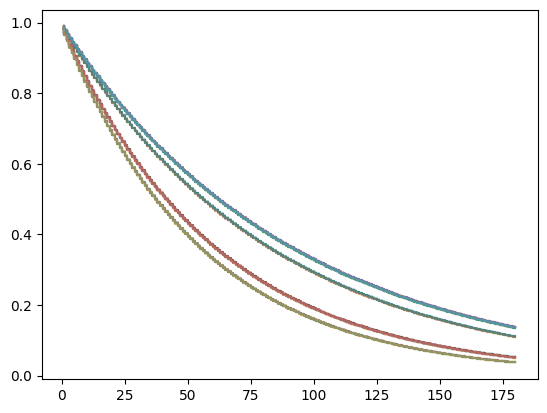

In [335]:
N = sv_true["sv_true"].shape[0]
for i in range(0,100):
    plt.step(sv_true["true_times"], sv_true["sv_true"][i,:], alpha=0.3)

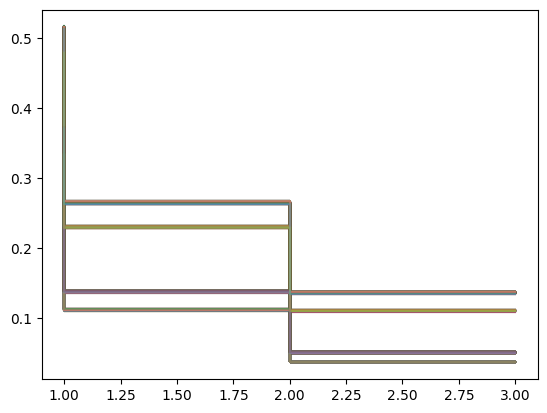

In [336]:

N = sv_scale_true["sv_true"].shape[0]
for i in range(0,N):
    plt.step(sv_scale_true["scale_times"], sv_scale_true["sv_true"][i,:], alpha=0.3)

## Survival Analyses

### Data Prep

The data needs to be transformed to a specific format, denoted as long-time form, to work for analyses.

The transformation can be completed through a series of functions.

1. `get_time_transform()`

    performs time down scaling

2. `get_y_sklearn()`
    
    sets format for outcomes event/status based on the sksurv type

3. `get_surv_pre_train()`

    generates long-time form of the training dataset

    weight should == None, outside of specific use-cases not examined here
    
    **time is incoporated into the covariate (x) matrix at index[:,0]**

4. `get_posterior_test()`

    generates long-time form for the posterior test dataset
    
    **time is incoporated into the covariate (x) matrixat index[:,0]**

In [337]:
# prepare data
t_scale = sb.get_time_transform(event_dict["t_event"], time_scale = 60)
y_sk = sb.get_y_sklearn(event_dict["status"], t_scale)
trn = sb.get_surv_pre_train(y_sk, x_mat, weight=None)
post_test = sb.get_posterior_test(y_sk=y_sk, x_test = x_mat)

In [338]:
print(trn.keys())
print(post_test.keys())

dict_keys(['y', 'x', 'w', 'coord'])
dict_keys(['post_x', 'coords'])


In [339]:
trn["x"].shape

(1589, 6)

### Train Model

The `BartSurvModel` contains the model. To initiate the class/model, two configuration parameters must be provided.

1. `model_config` 
    
    set of parameters specific to the BART model
    
    - `trees` is the number of trees to generate
    - `split_rules` defines the type of data in each covariate
      - the split rules should be ordered in the order of the covariates
      - time is the first covariate and will always be "pmb.ContinuousSplitRule()"
      - OneHotSplitRule is used for categorical variables
      - ContinuousSplitRule is used for continuous variables

2. `sample_config`

    set of parameters specific to the Sampling procedure


In [340]:
SPLIT_RULES =  [
    "pmb.ContinuousSplitRule()", # time
    "pmb.OneHotSplitRule", # x_mat[:,0]
    "pmb.OneHotSplitRule", # x_mat[:,1]
    "pmb.ContinuousSplitRule()", # x_mat[:,2]
    "pmb.ContinuousSplitRule()", # x_mat[:,3]
    "pmb.ContinuousSplitRule()", # x_mat[:,4]
]

model_dict = {"trees": 40,
    "split_rules": SPLIT_RULES
}
sampler_dict = {
            "draws": 200,
            "tune": 200,
            "cores": 8,
            "chains": 8,
            "compute_convergence_checks": False
        }

BSM = sb.BartSurvModel(model_config=model_dict, sampler_config=sampler_dict)

The model can be trained with `.fit()`

All components to train the model should be contained in the dict `trn` (output of get_surv_pre_train)

In [341]:
BSM.fit(
    y =  trn["y"],
    X = trn["x"],
    weights=trn["w"],
    coords = trn["coord"],
    random_seed=5
)

Only 200 samples in chain.
Multiprocess sampling (8 chains in 8 jobs)
PGBART: [f]


Sampling 8 chains for 200 tune and 200 draw iterations (1_600 + 1_600 draws total) took 50 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> predictor_names
	> offset

BART does not provide coefficients from the trained model, like seen in linear regression or a Cox model. 

Instead in the context of survival, posterior predictions must be collected to evaluate the model.

This is completed using `sample_posterior_predictive()` and the `post_test` datasets.

In [342]:
post1 = BSM.sample_posterior_predictive(X_pred=post_test["post_x"], coords=post_test["coords"])

Sampling: [f]


In [343]:
post1.mu

<xarray.DataArray 'mu' (sample: 1600, p_obs: 3000)>
array([[0.50622246, 0.47711782, 0.4901674 , ..., 0.4674481 , 0.48815353,
        0.50121293],
       [0.59756572, 0.59047462, 0.61211048, ..., 0.51129146, 0.50399816,
        0.52634292],
       [0.58422913, 0.57660954, 0.57660954, ..., 0.52813872, 0.52813872,
        0.52813872],
       ...,
       [0.55040646, 0.57136304, 0.57136304, ..., 0.42885956, 0.44392499,
        0.44392499],
       [0.44462813, 0.4170002 , 0.4170002 , ..., 0.47474797, 0.44136051,
        0.44136051],
       [0.50401269, 0.49038163, 0.52859777, ..., 0.45619941, 0.44267766,
        0.48072809]])
Coordinates:
  * p_obs    (p_obs) int64 0 0 0 1 1 1 2 2 2 ... 997 997 998 998 998 999 999 999
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 7 7 7 7 7 7 7 7 7 7 7 7
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199

`post1.mu` is a series of observation\*time probability values predicted for each observation\*time combination. Sets of these values are collected from draws during the sampling procudure, providing the probability distribution of the value.

`post1.mu` is not yet the SV probability. It is more similar to the hazard rate, but it is not exactly interpreted as a hazard rate (since it is a probability).

The SV probability can further be derived with `get_sv_prob()`
- `sv_prob` variable contains the SV probability and the mu (hazard-like) probability. 
- Each array is formatted with the dimension:
  
  (draw, obs, time)

In [344]:
sv_prob = sb.get_sv_prob(post1)

In [345]:
print("Draw 1, Obs 1, mu prob values at time [1,2,3,4,5,6]")
print(sv_prob["prob"][0, 0:1, :])
print("Draw1, Obs 1, sv prob values at time [1,2,3,4,5,6]")
print(sv_prob["sv"][0, 0:1, :])

Draw 1, Obs 1, mu prob values at time [1,2,3,4,5,6]
[[0.50622246 0.47711782 0.4901674 ]]
Draw1, Obs 1, sv prob values at time [1,2,3,4,5,6]
[[0.49377754 0.25818747 0.13163239]]


The predicted values can be compared to the true values.

This is where having the scaled true values is useful.

In [346]:
sv_scale_true["sv_true"]

array([[0.51445381, 0.26466272, 0.13615675],
       [0.47875479, 0.22920615, 0.10973354],
       [0.3336275 , 0.11130731, 0.03713518],
       ...,
       [0.37195378, 0.13834962, 0.05145966],
       [0.47911443, 0.22955064, 0.10998102],
       [0.51349938, 0.26368161, 0.13540034]])

In [347]:
sv_prob["sv"].mean(0)

array([[0.48352278, 0.24335829, 0.12290693],
       [0.45524757, 0.21542661, 0.10397981],
       [0.29181296, 0.09242356, 0.02923717],
       ...,
       [0.35157051, 0.12688194, 0.04520213],
       [0.45754721, 0.22036886, 0.10755788],
       [0.51669868, 0.27126734, 0.14509143]])

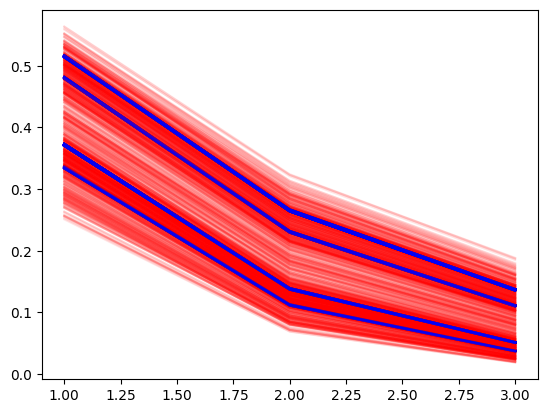

In [348]:
sv_ave = sv_prob["sv"].mean(0)
N = sv_ave.shape[0]
tttimes = np.unique(y_sk["Survival_in_days"])

# Do for the first 10
for i in range(0,N):
    plt.plot(tttimes, sv_ave[i,:], color = "red", alpha =0.1)
    plt.plot(tttimes[:], sv_scale_true["sv_true"][i,:], color = "blue", alpha =0.2)
    # sv_scale_true["sv_true"].shape

Additionally, metrics like RMSE can be derived against the True SV

In [460]:
rmse = np.sqrt((np.power((sv_ave - sv_scale_true["sv_true"]),2)).sum(0)/N)
print("RMSE")
[print(r) for r in rmse]

RMSE
0.035630245172288924
0.026119798288288545
0.016913921087137327


[None, None, None]

Additional evaluations like the Hazard Ratio (as Risk Ratio) and Marginal Distribution Effects can be derived to further evaluate a variables impact on the outcome.

This is completed through Partial Dependence Functions. Simply explained, PD functions are evaluations of the model with conterfactual type data. 

If examining the first covariate, a counterfactual dataset with the variable set to its opposite value is derived and passed through the `sample_posterior_predictive` to return posterior predictions used to evaluate the marginal effects.

- `get_pdp()`
  - generates the pdp dataset
  - key parameters
    - `var_col` 
      - covariate column selected 
      - can be upto 2 variables
    - `values`
      - list of lists counterfactual values
  

In [409]:
pdp1 = sb.get_pdp(x_mat, var_col = [0], values = [[0,1]], sample_n = None)
pdp_tst = sb.get_posterior_test(y_sk, pdp1[0])
pdp_post = BSM.sample_posterior_predictive(pdp_tst["post_x"], pdp_tst["coords"])

Sampling: [f]


In [410]:
pdp_sv_prob = sb.get_sv_prob(pdp_post)
# pdp_sv_prob datasets are N*values in length

Hazard Ratio can be derived by dividing the pdp[val=1]/pdp[val=0].
With continuous values, values can be selected as the standard unit increase of the variable. Or moving away from a direct HR interpretation, broader range of values could be selected such as "age 60 / age 20" if age was a variable. While this wouldn't be equivalent to the HR, it could be a useful metric in some studies.

This provides a Risk Ratio at each time point and taken as an average over all time points provides a Hazard Ratio is an assumption of proportional hazard.

The detected HR can be compared to the actual HR through the $exp(-B_n)$ used in the `scale_f` equation.

Note that if the `scale_f` or `shape_f` is paramaterized with more complex equations, this method of deriving the actual HR will not work.

In [412]:
msk_1 = pdp1[1]["coord"] == 1
RR = (pdp_sv_prob["prob"][:,msk_1,:].mean(1) / pdp_sv_prob["prob"][:,~msk_1,:].mean(1)).mean(0)
HR = RR.mean()
print(RR)
print(HR)
print(np.exp(-.4))

[0.78609195 0.7799938  0.7722544 ]
0.7794467187704361
0.6703200460356392


Repeating the process for the other variables parameterized in `scale_f`

In [413]:
HR_L = []
for i in range(0,5):
    pdp1 = sb.get_pdp(x_mat, var_col = [i], values = [[0,1]], sample_n = None)
    pdp_tst = sb.get_posterior_test(y_sk, pdp1[0])
    pdp_post = BSM.sample_posterior_predictive(pdp_tst["post_x"], pdp_tst["coords"])
    pdp_sv_prob = sb.get_sv_prob(pdp_post)
    msk_1 = pdp1[1]["coord"] == 1
    RR = (pdp_sv_prob["prob"][:,msk_1,:].mean(1) / pdp_sv_prob["prob"][:,~msk_1,:].mean(1)).mean(0)
    HR_L.append(RR.mean())

Sampling: [f]


Sampling: [f]


Sampling: [f]


Sampling: [f]


Sampling: [f]


In [445]:
# Using the orignal scale_f equation, the True HR can be dreived
# np.exp(4 + .4*x_mat[:,0] + .1*x_mat[:,1] + .01*x_mat[:,2])", # note that x_mat[:,3] and x_mat[:,4] are not included

print(f"x0 true {np.exp(-.4)} : pred {HR_L[0]}")
print(f"x1 true {np.exp(-.1)} : pred {HR_L[1]}")
print(f"x2 true {np.exp(-.01)} : pred {HR_L[2]}")
print(f"x2 true {np.exp(0)} : pred {HR_L[3]}")
print(f"x2 true {np.exp(-0)} : pred {HR_L[4]}")


x0 true 0.6703200460356392 : pred 0.7789190061701176
x1 true 0.9048374180359595 : pred 0.9083690381510903
x2 true 0.9900498337491681 : pred 1.0884937903832543
x2 true 1.0 : pred 0.98367912357184
x2 true 1.0 : pred 1.0790398900712959


## Cox Proportional Hazard Model
As a comparison, the simulated data can be analyzed with a Cox Proportional Hazard Model.

In [122]:
from sksurv import linear_model
import lifelines as ll
import pandas as pd

0.3678794411714424

In [459]:

# reformat the data into a pandas dataframe
tmp = np.hstack([x_mat, y_sk["Survival_in_days"].reshape(-1,1), y_sk["Status"].reshape(-1,1)])
pdf = pd.DataFrame(tmp)
pdf.columns = ["x1", "x2", "x3", "x4", "x5", "t", "s"]
print(pdf.head())

    x1   x2     x3        x4        x5    t    s
0  1.0  1.0  0.284  0.115267  0.688936  3.0  0.0
1  1.0  0.0  0.010  0.878597  0.531591  1.0  1.0
2  0.0  0.0  0.110  0.299339  0.742602  3.0  1.0
3  1.0  1.0  0.131  0.745929  0.897600  3.0  0.0
4  0.0  1.0  0.432  0.937366  0.457821  1.0  1.0


In [438]:
CPH = ll.CoxPHFitter()
# Fit the model 
CPH.fit(pdf, duration_col = "t", event_col = "s", formula = "x1 + x2 + x3 +x4 +x5")
CPH.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
x1,-0.386883,0.679170,0.066661,-0.517537,-0.256230,0.595987,0.773964,0.0,-5.803730,6.485555e-09,27.200123
x2,-0.171932,0.842036,0.073163,-0.315329,-0.028535,0.729549,0.971868,0.0,-2.349987,1.877408e-02,5.735114
x3,0.174925,1.191157,0.111070,-0.042769,0.392619,0.958133,1.480853,0.0,1.574904,1.152787e-01,3.116802
x4,-0.067710,0.934531,0.114030,-0.291205,0.155784,0.747363,1.168574,0.0,-0.593796,5.526483e-01,0.855566
x5,0.209524,1.233091,0.116931,-0.019657,0.438705,0.980535,1.550698,0.0,1.791856,7.315606e-02,3.772879


The predicted SV probabilites can also be collected and compared to the True Sv probabilites.

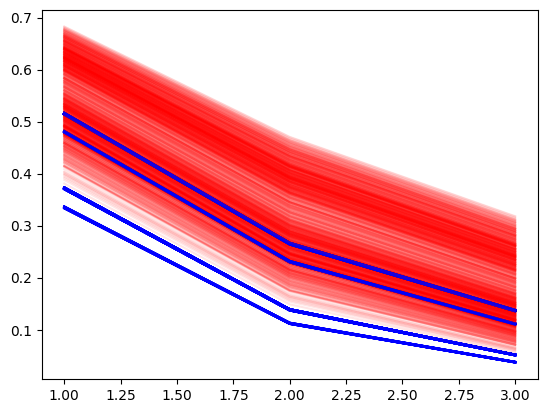

In [439]:
# Display predicted values against the True Values
cph_surv = CPH.predict_survival_function(pdf).T.to_numpy()
for i in range(0,N):
    plt.plot(tttimes, cph_surv[i,:], color = "red", alpha =0.1)
    plt.plot(tttimes[:], sv_scale_true["sv_true"][i,:], color = "blue", alpha =0.2)
    # sv_scale_true["sv_true"].shape

Notably these predictions at baseline are not falling into the range of the True values.

Examination of the hazard ratios in comparison with the True HR can be made.

In [456]:
cph_hr = CPH.hazard_ratios_.to_numpy()
print("CPH HR")
print(f"x0 true {np.exp(-.4)} : pred {cph_hr[0]}")
print(f"x1 true {np.exp(-.1)} : pred {cph_hr[1]}")
print(f"x2 true {np.exp(-.01)} : pred {cph_hr[2]}")
print(f"x2 true {np.exp(0)} : pred {cph_hr[3]}")
print(f"x2 true {np.exp(-0)} : pred {cph_hr[4]}")

print("\n BART HR")
print(f"x0 true {np.exp(-.4)} : pred {HR_L[0]}")
print(f"x1 true {np.exp(-.1)} : pred {HR_L[1]}")
print(f"x2 true {np.exp(-.01)} : pred {HR_L[2]}")
print(f"x2 true {np.exp(0)} : pred {HR_L[3]}")
print(f"x2 true {np.exp(-0)} : pred {HR_L[4]}")


CPH HR
x0 true 0.6703200460356392 : pred 0.6791702610696051
x1 true 0.9048374180359595 : pred 0.8420364683624689
x2 true 0.9900498337491681 : pred 1.191156777744076
x2 true 1.0 : pred 0.9345309994227077
x2 true 1.0 : pred 1.2330908662975828

 BART HR
x0 true 0.6703200460356392 : pred 0.7789190061701176
x1 true 0.9048374180359595 : pred 0.9083690381510903
x2 true 0.9900498337491681 : pred 1.0884937903832543
x2 true 1.0 : pred 0.98367912357184
x2 true 1.0 : pred 1.0790398900712959
